# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

<b>
<font color = brown> 
    Following Libraries were installed
<font color = blue>
    <br>scipy==1.7.3
    <br>imageio==2.19.3
    <br>scikit-image==0.19.2
    <br>tensorflow==2.6.0
    <br>tensorflow-gpu==2.6.0
    <br>keras==2.6.0
    <br>numpy==1.19.5
    <br>numba==0.55.1
    <br>cudatoolkit==11.3.1 (via anaconda)

In [1]:
# Display CPU/GPU availability
import os 
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"]="true" 

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1179284939948550730
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1304434688
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2332673428846511593
physical_device_desc: "device: 0, name: NVIDIA GeForce MX450, pci bus id: 0000:01:00.0, compute capability: 7.5"
]


In [2]:
import numpy as np
#import os
#from scipy.misc import imread, imresize
from imageio.v2 import imread
from skimage.transform import resize as imresize
import datetime
from PIL import Image, ImageFilter, ImageEnhance
import matplotlib.pyplot as plt

We set the random seed so that the results don't vary drastically.

In [3]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In [4]:
from numba import jit, cuda
import warnings
# warnings.filterwarnings("ignore")

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [5]:
train_doc = np.random.permutation(open('Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('Project_data/val.csv').readlines())
batch_size = 20

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [6]:
def fn_print_header(msg):
    print(100 * "-")
    print(msg)
    print(100 * "-", "\n")

def fn_print_msg( msg):
    print(f'==> {msg}')

In [7]:
def generator(source_path, folder_list, batch_size, frames, x_dim, y_dim):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = np.round(np.linspace(0,29,frames)).astype(int)
    while True:
        t = np.random.permutation(folder_list)        
        num_batches = int(len(t)/batch_size) # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches            
            batch_data = np.zeros((batch_size, frames, x_dim, y_dim, 3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size, 5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0] + '/' +
                                   imgs[item]).astype(np.float32)
                    image = imresize(image, (x_dim, y_dim))
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    batch_data[folder, idx, :, :, 0] = (image[:, :, 0])/255 #normalise and feed in the image
                    batch_data[folder, idx, :, :, 1] = (image[:, :, 1])/255 #normalise and feed in the image
                    batch_data[folder, idx, :, :, 2] = (image[:, :, 2])/255 #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if len(folder_list)%batch_size != 0:
            batch_size = len(folder_list) % batch_size
            batch_data = np.zeros((batch_size, frames, x_dim, y_dim, 3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size, 5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0] + '/' + 
                                   imgs[item]).astype(np.float32)
                    image = imresize(image, (x_dim, y_dim))
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    batch_data[folder, idx, :, :, 0] = (image[:, :, 0])/255 #normalise and feed in the image
                    batch_data[folder, idx, :, :, 1] = (image[:, :, 1])/255 #normalise and feed in the image
                    batch_data[folder, idx, :, :, 2] = (image[:, :, 2])/255 #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [8]:
curr_dt_time = datetime.datetime.now()
train_path = 'Project_data/train'
val_path = 'Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 20


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

## Model_1 with SGD Optimizer

In [9]:
from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

#write your model here
model = Sequential()
model.add(Conv3D(16, (2,2,2), padding='same', input_shape=(20,75,75,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(32, (2,2,2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(64, (2,2,2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(64,activation='relu'))
model.add(BatchNormalization())

model.add(Dense(5, activation='softmax'))

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [10]:
def fn_model_compile(model, opt_type):
    if opt_type == 'SGD':
        optimiser = tf.keras.optimizers.SGD(learning_rate=0.001, decay=1e-6, momentum=0.7, nesterov=True) #write your optimizer
    elif opt_type == 'Adam':
        optimiser = tf.keras.optimizers.Adam()
    else:
        fn_print_msg("ERROR: Invalid Optimise Type")
    
    ret_model = model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    print (model.summary())
    return ret_model

fn_print_header("Printing Base model_1 [SGD] Summary")
model_1 = fn_model_compile(model, 'SGD')

----------------------------------------------------------------------------------------------------
Printing Base model_1 [SGD] Summary
---------------------------------------------------------------------------------------------------- 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 20, 75, 75, 16)    400       
_________________________________________________________________
activation (Activation)      (None, 20, 75, 75, 16)    0         
_________________________________________________________________
batch_normalization (BatchNo (None, 20, 75, 75, 16)    64        
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 10, 37, 37, 16)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 10, 37, 37, 32)    4128      
______________

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [11]:
def fn_val_train_generator(frames, x_dim, y_dim):
    train_generator = generator(train_path, train_doc, batch_size, frames, x_dim, y_dim)
    val_generator = generator(val_path, val_doc, batch_size, frames, x_dim, y_dim)
    return train_generator, val_generator
    

In [12]:
def fn_model_checkpoint(modelname):
    model_name = modelname + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

    if not os.path.exists(model_name):
        os.mkdir(model_name)

    filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')

    LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', min_delta=0.0001, cooldown=0, min_lr=0.00001) # write the REducelronplateau code here
    callbacks_list = [checkpoint, LR]
    
    return callbacks_list

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [13]:
def fn_val_epoch_steps():
    if (num_train_sequences % batch_size) == 0:
        steps_per_epoch = int(num_train_sequences / batch_size)
    else:
        steps_per_epoch = (num_train_sequences // batch_size) + 1

    if (num_val_sequences % batch_size) == 0:
        validation_steps = int(num_val_sequences / batch_size)
    else:
        validation_steps = (num_val_sequences // batch_size) + 1
        
    return steps_per_epoch, validation_steps

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [14]:
def fn_session_config():
    config = tf.compat.v1.ConfigProto()
    config.gpu_options.allow_growth = True
    config.gpu_options.per_process_gpu_memory_fraction = 0.85

    try:
        session
    except NameError:
        pass
    else:
        tf.compat.v1.InteractiveSession.close(session) 

    session = tf.compat.v1.Session(config=config)
    session.as_default()

In [15]:

def fn_fit(train_generator, val_generator, steps_per_epoch, validation_steps, callbacks_list):
    return model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

In [16]:
model_name = "Model_1"
frames = 20
x_dim = 75
y_dim = 75

train_generator, val_generator = fn_val_train_generator(frames, x_dim, y_dim)
callbacks_list = fn_model_checkpoint(model_name)
steps_per_epoch, validation_steps = fn_val_epoch_steps()
fn_session_config()

fn_print_header(f"Running Base {model_name} Fit")    
model_1 = fn_fit(train_generator, val_generator, steps_per_epoch, validation_steps, callbacks_list)


----------------------------------------------------------------------------------------------------
Running Base Model_1 Fit
---------------------------------------------------------------------------------------------------- 

Source path =  Project_data/train ; batch size = 20
Epoch 1/20
34/34 [==============================] - 228s 6s/step - loss: 1.6776 - categorical_accuracy: 0.3846 - val_loss: 1.8487 - val_categorical_accuracy: 0.1600

Epoch 00001: saving model to Model_1_2022-11-1608_44_22.194016\model-00001-1.67764-0.38462-1.84874-0.16000.h5
Epoch 2/20
34/34 [==============================] - 64s 2s/step - loss: 1.6233 - categorical_accuracy: 0.4216 - val_loss: 2.2036 - val_categorical_accuracy: 0.2500

Epoch 00002: saving model to Model_1_2022-11-1608_44_22.194016\model-00002-1.62329-0.42157-2.20360-0.25000.h5
Epoch 3/20
34/34 [==============================] - 66s 2s/step - loss: 2.0490 - categorical_accuracy: 0.2941 - val_loss: 2.7557 - val_categorical_accuracy: 0.2500

Epo

----------------------------------------------------------------------------------------------------
Visualize Training Results for Model_2
---------------------------------------------------------------------------------------------------- 



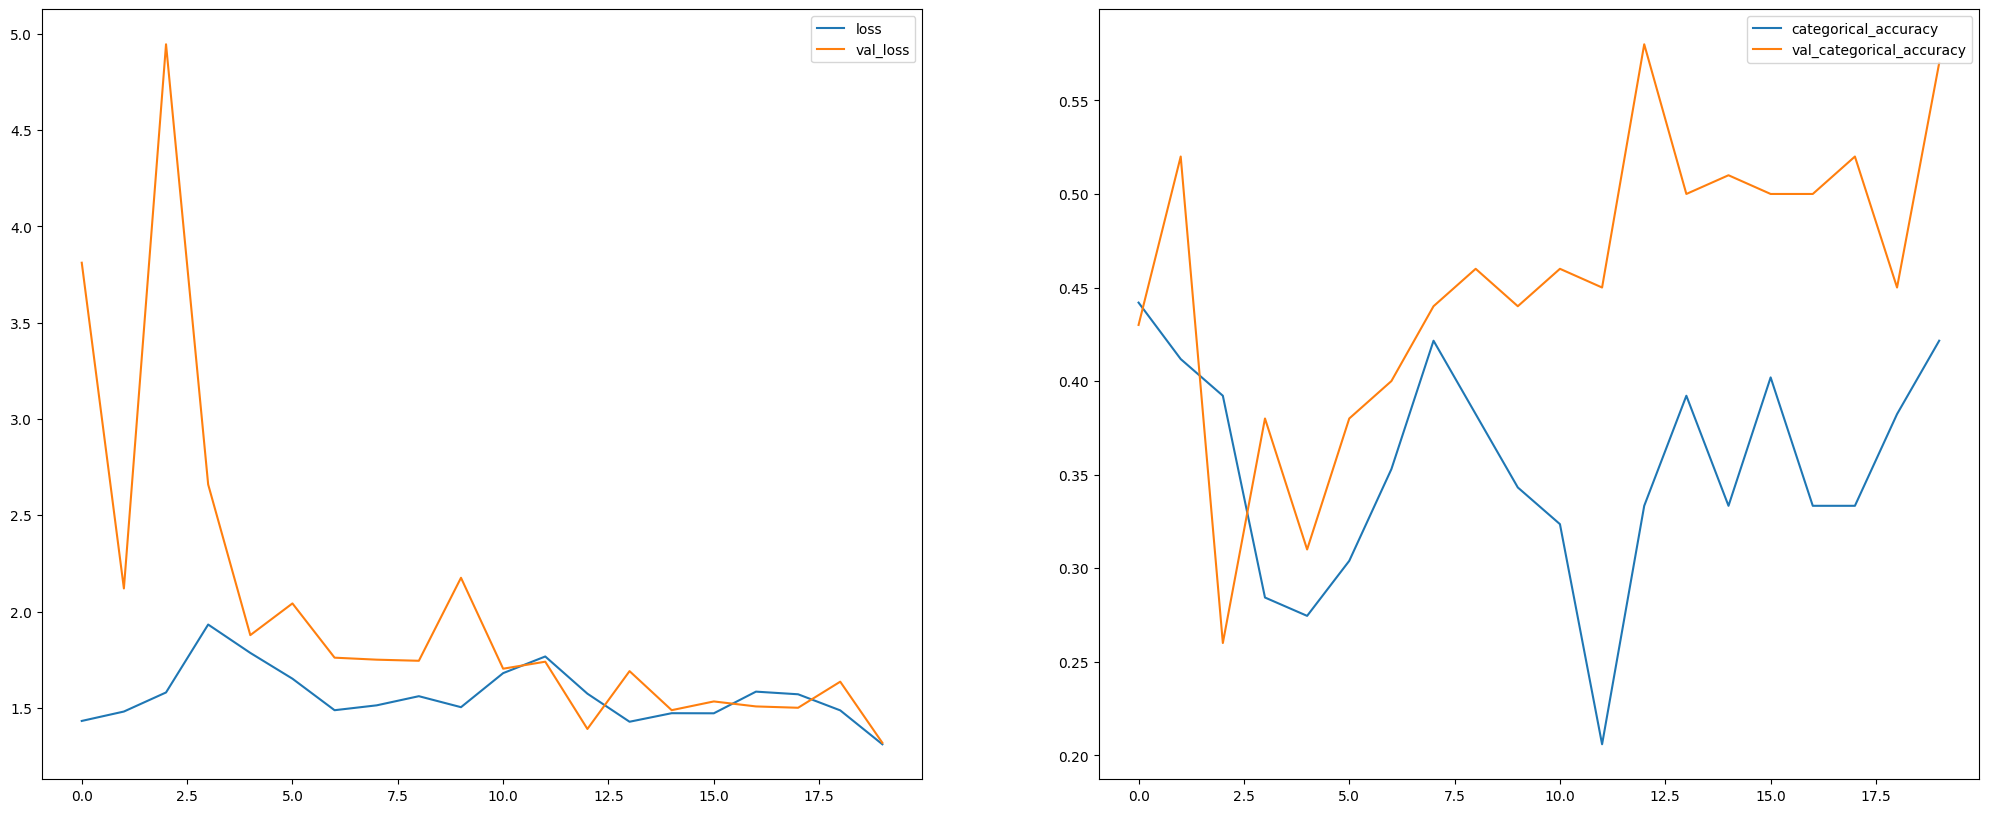

In [24]:
def fn_plot_model_accuracy(model):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(25,10))
    axes[0].plot(model.history.history['loss'])   
    axes[0].plot(model.history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])
    axes[1].plot(model.history.history['categorical_accuracy'])   
    axes[1].plot(model.history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])
    plt.show()
    
fn_print_header(f"Visualize Training Results for {model_name}")
fn_plot_model_accuracy(model)

<font color = blue>  
    <b> -- OBSERVATION: Model fits well but has low accurracy 
    <br>

## Model_2 with Adam optimizer

In [18]:
# NOTE: Model Paramters same as Model_1

model_name = "Model_2"

fn_print_header(f"Printing Base {model_name} Summary")
model_2 = fn_model_compile(model, 'Adam')

----------------------------------------------------------------------------------------------------
Printing Base Model_2 Summary
---------------------------------------------------------------------------------------------------- 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 20, 75, 75, 16)    400       
_________________________________________________________________
activation (Activation)      (None, 20, 75, 75, 16)    0         
_________________________________________________________________
batch_normalization (BatchNo (None, 20, 75, 75, 16)    64        
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 10, 37, 37, 16)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 10, 37, 37, 32)    4128      
____________________

In [19]:
train_generator, val_generator = fn_val_train_generator(frames, x_dim, y_dim)
callbacks_list = fn_model_checkpoint(model_name)
steps_per_epoch, validation_steps = fn_val_epoch_steps()
fn_session_config()

In [20]:
fn_print_header(f"Running {model_name} Fit")    
model_2 = fn_fit(train_generator, val_generator, steps_per_epoch, validation_steps, callbacks_list)

----------------------------------------------------------------------------------------------------
Running Model_2 Fit
---------------------------------------------------------------------------------------------------- 

Source path =  Project_data/train ; batch size = 20
Epoch 1/20
34/34 [==============================] - 213s 6s/step - loss: 1.4323 - categorical_accuracy: 0.4419 - val_loss: 3.8110 - val_categorical_accuracy: 0.4300

Epoch 00001: saving model to Model_2_2022-11-1608_44_22.194016\model-00001-1.43225-0.44193-3.81098-0.43000.h5
Epoch 2/20
34/34 [==============================] - 48s 1s/step - loss: 1.4811 - categorical_accuracy: 0.4118 - val_loss: 2.1200 - val_categorical_accuracy: 0.5200

Epoch 00002: saving model to Model_2_2022-11-1608_44_22.194016\model-00002-1.48106-0.41176-2.11998-0.52000.h5
Epoch 3/20
34/34 [==============================] - 52s 2s/step - loss: 1.5801 - categorical_accuracy: 0.3922 - val_loss: 4.9450 - val_categorical_accuracy: 0.2600

Epoch 00

----------------------------------------------------------------------------------------------------
Visualize Training Results for Model_2
---------------------------------------------------------------------------------------------------- 



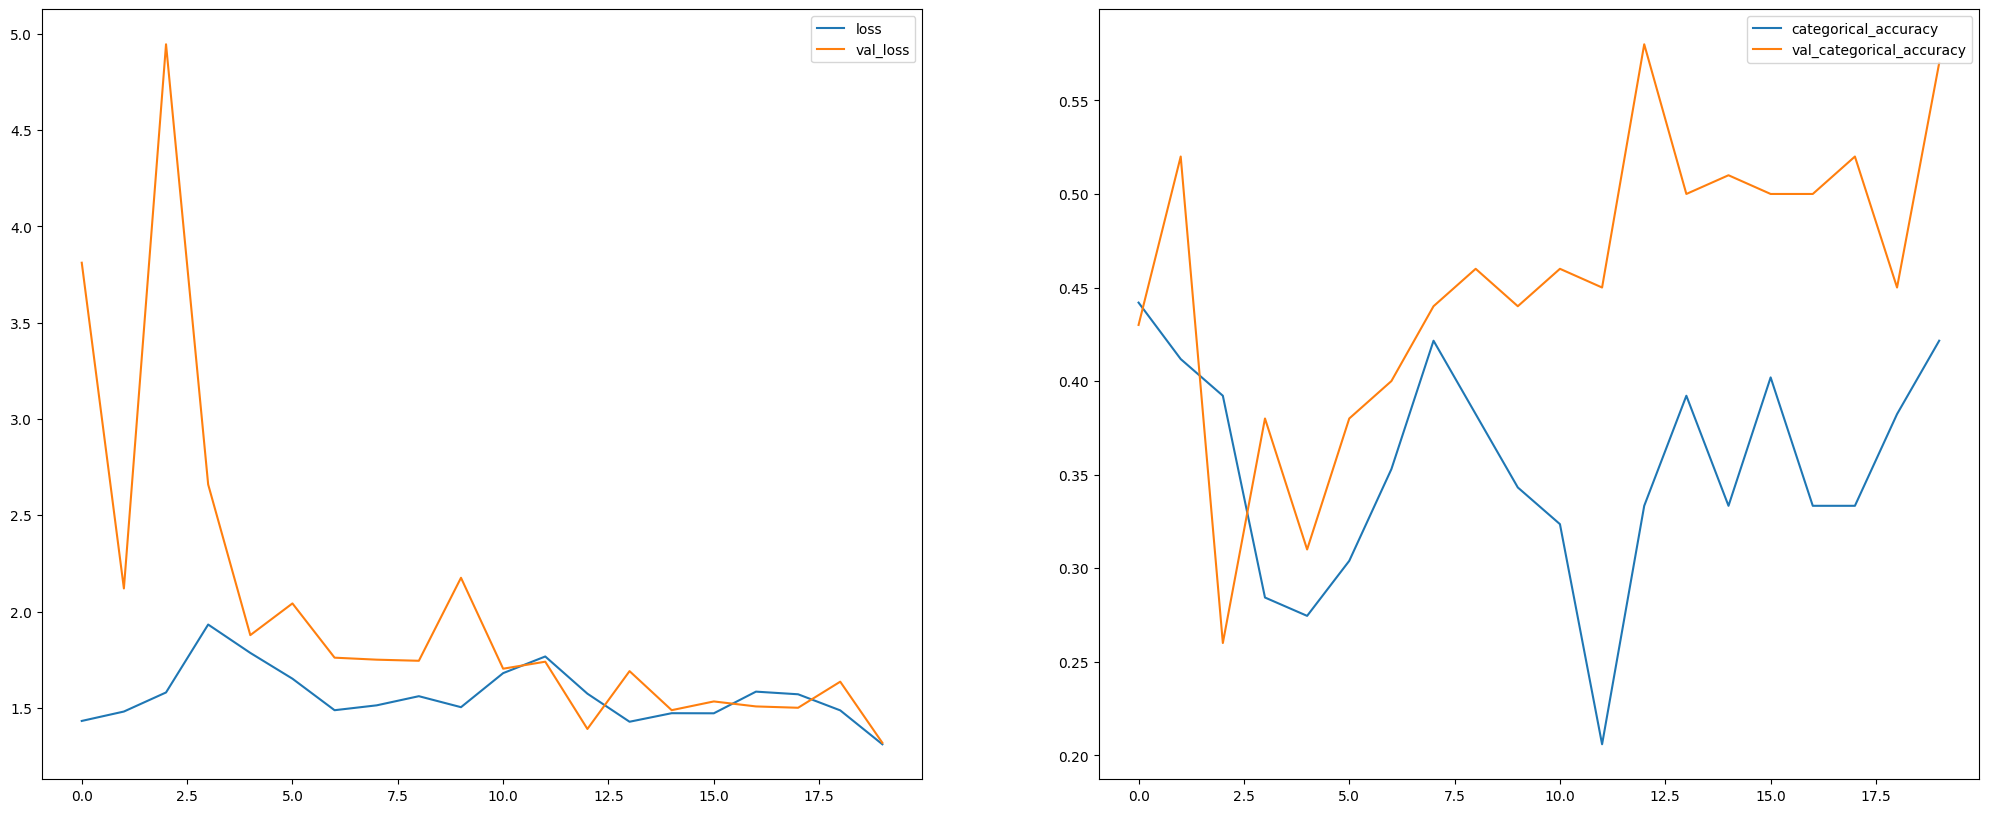

In [23]:
fn_print_header(f"Visualize Training Results for {model_name}")
fn_plot_model_accuracy(model)

<font color = blue>  
    <b> -- OBSERVATION: Model accurracy improved but is still low
    <br>

## Model_3 with with reduced paramters

In [26]:
model = Sequential()
model.add(Conv3D(16, (2,2,2), padding='same', input_shape=(20,75,75,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(32, (2,2,2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(64, (2,2,2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Flatten())
#model.add(Dense(128, activation='relu'))
#model.add(BatchNormalization())
#model.add(Dropout(0.5))

model.add(Dense(64,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(5, activation='softmax'))

In [27]:
model_name = "Model_3"

fn_print_header(f"Printing {model_name} Summary")
model_3 = fn_model_compile(model, 'Adam')

----------------------------------------------------------------------------------------------------
Printing Model_3 Summary
---------------------------------------------------------------------------------------------------- 

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_3 (Conv3D)            (None, 20, 75, 75, 16)    400       
_________________________________________________________________
activation_3 (Activation)    (None, 20, 75, 75, 16)    0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 20, 75, 75, 16)    64        
_________________________________________________________________
max_pooling3d_3 (MaxPooling3 (None, 10, 37, 37, 16)    0         
_________________________________________________________________
conv3d_4 (Conv3D)            (None, 10, 37, 37, 32)    4128      
_______________________

In [28]:
train_generator, val_generator = fn_val_train_generator(frames, x_dim, y_dim)
callbacks_list = fn_model_checkpoint(model_name)
steps_per_epoch, validation_steps = fn_val_epoch_steps()
fn_session_config()

fn_print_header(f"Running {model_name} Fit")    
model_3 = fn_fit(train_generator, val_generator, steps_per_epoch, validation_steps, callbacks_list)

----------------------------------------------------------------------------------------------------
Running Model_3 Fit
---------------------------------------------------------------------------------------------------- 

Source path =  Project_data/train ; batch size = 20
Epoch 1/20
34/34 [==============================] - 247s 7s/step - loss: 1.2862 - categorical_accuracy: 0.5173 - val_loss: 4.3866 - val_categorical_accuracy: 0.2100

Epoch 00001: saving model to Model_3_2022-11-1608_44_22.194016\model-00001-1.28618-0.51735-4.38659-0.21000.h5
Epoch 2/20
34/34 [==============================] - 71s 2s/step - loss: 1.0998 - categorical_accuracy: 0.5980 - val_loss: 14.2105 - val_categorical_accuracy: 0.2000

Epoch 00002: saving model to Model_3_2022-11-1608_44_22.194016\model-00002-1.09978-0.59804-14.21045-0.20000.h5
Epoch 3/20
34/34 [==============================] - 72s 2s/step - loss: 1.1619 - categorical_accuracy: 0.5686 - val_loss: 20.6344 - val_categorical_accuracy: 0.2300

Epoch

----------------------------------------------------------------------------------------------------
Visualize Training Results for Model_3
---------------------------------------------------------------------------------------------------- 



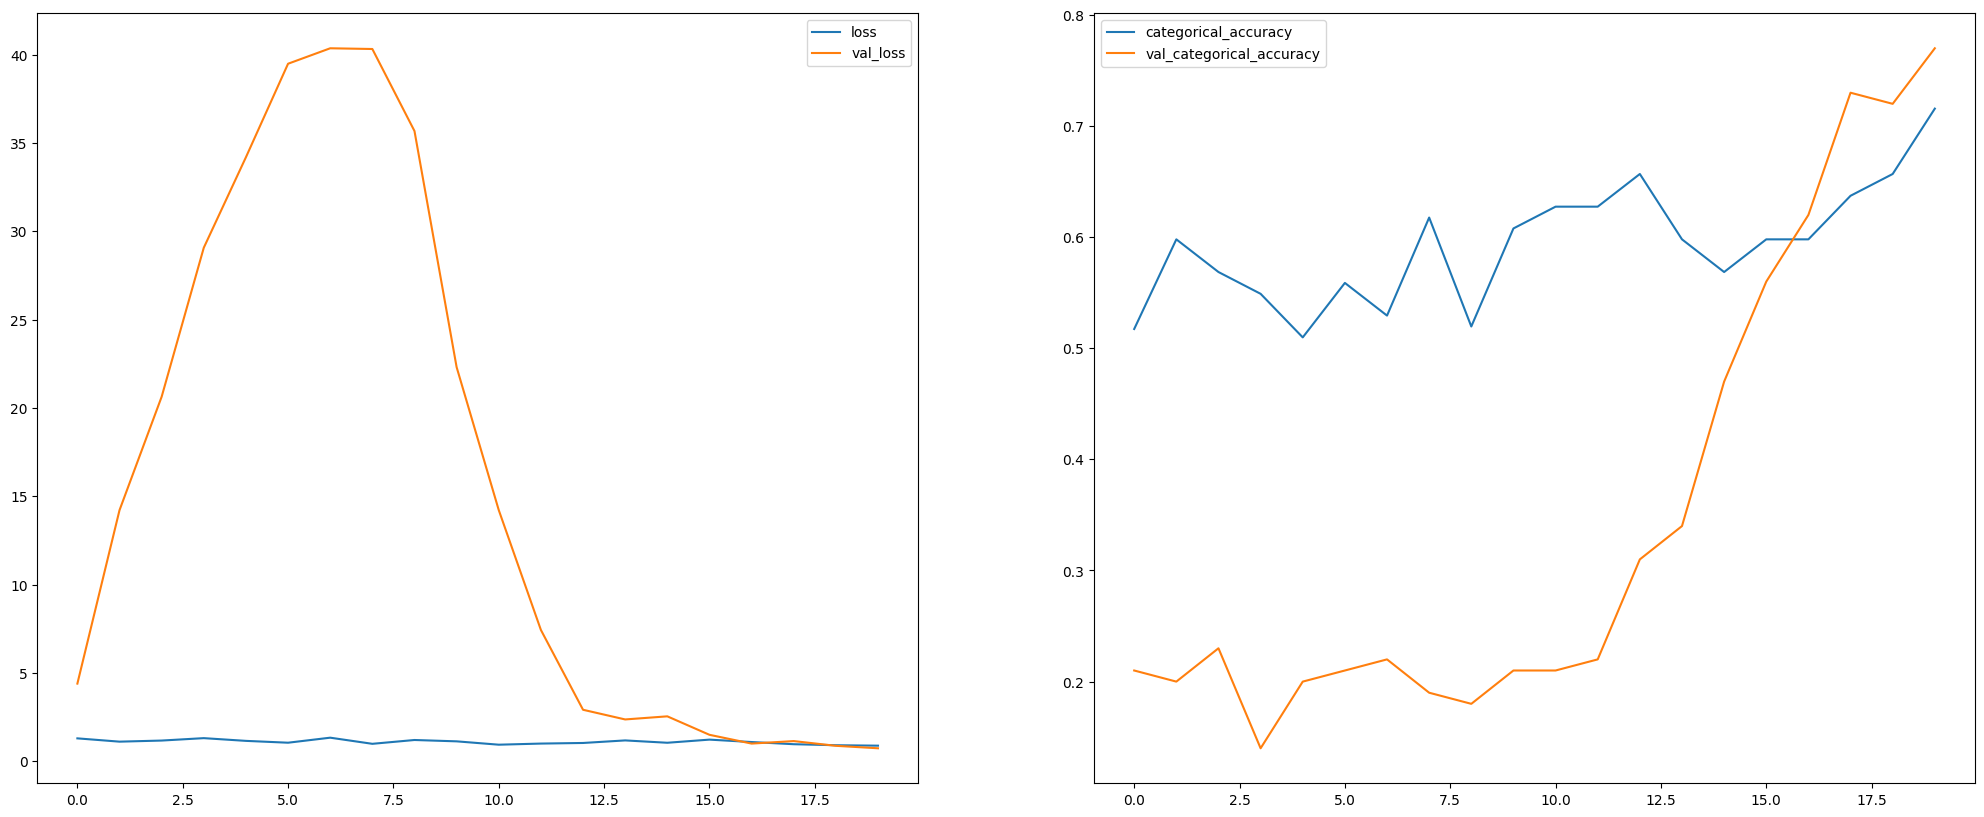

In [29]:
fn_print_header(f"Visualize Training Results for {model_name}")
fn_plot_model_accuracy(model)

<font color = blue>  
    <b> -- OBSERVATION: Accurracy Improved with reduced paramters. 
    <br>

## Model_4 with increased filter size 

In [30]:
model = Sequential()
model.add(Conv3D(16, (3,3,3), padding='same', input_shape=(20,75,75,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(32, (3,3,3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(64, (3,3,3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Flatten())
#model.add(Dense(128, activation='relu'))
#model.add(BatchNormalization())
#model.add(Dropout(0.5))

model.add(Dense(64,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(5, activation='softmax'))

In [31]:
model_name = "Model_4"

fn_print_header(f"Printing {model_name} Summary")
model_4 = fn_model_compile(model, 'Adam')

----------------------------------------------------------------------------------------------------
Printing Model_4 Summary
---------------------------------------------------------------------------------------------------- 

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_6 (Conv3D)            (None, 20, 75, 75, 16)    1312      
_________________________________________________________________
activation_6 (Activation)    (None, 20, 75, 75, 16)    0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 20, 75, 75, 16)    64        
_________________________________________________________________
max_pooling3d_6 (MaxPooling3 (None, 10, 37, 37, 16)    0         
_________________________________________________________________
conv3d_7 (Conv3D)            (None, 10, 37, 37, 32)    13856     
_______________________

In [32]:
train_generator, val_generator = fn_val_train_generator(frames, x_dim, y_dim)
callbacks_list = fn_model_checkpoint(model_name)
steps_per_epoch, validation_steps = fn_val_epoch_steps()
fn_session_config()

fn_print_header(f"Running {model_name} Fit")    
model_4 = fn_fit(train_generator, val_generator, steps_per_epoch, validation_steps, callbacks_list)

----------------------------------------------------------------------------------------------------
Running Model_4 Fit
---------------------------------------------------------------------------------------------------- 

Source path =  Project_data/train ; batch size = 20
Epoch 1/20
34/34 [==============================] - 241s 7s/step - loss: 1.4800 - categorical_accuracy: 0.4510 - val_loss: 2.8402 - val_categorical_accuracy: 0.1800

Epoch 00001: saving model to Model_4_2022-11-1608_44_22.194016\model-00001-1.47997-0.45098-2.84018-0.18000.h5
Epoch 2/20
34/34 [==============================] - 74s 2s/step - loss: 1.2753 - categorical_accuracy: 0.5196 - val_loss: 4.2863 - val_categorical_accuracy: 0.2700

Epoch 00002: saving model to Model_4_2022-11-1608_44_22.194016\model-00002-1.27532-0.51961-4.28625-0.27000.h5
Epoch 3/20
34/34 [==============================] - 74s 2s/step - loss: 1.6003 - categorical_accuracy: 0.3725 - val_loss: 3.0753 - val_categorical_accuracy: 0.1900

Epoch 00

----------------------------------------------------------------------------------------------------
Visualize Training Results for Model_4
---------------------------------------------------------------------------------------------------- 



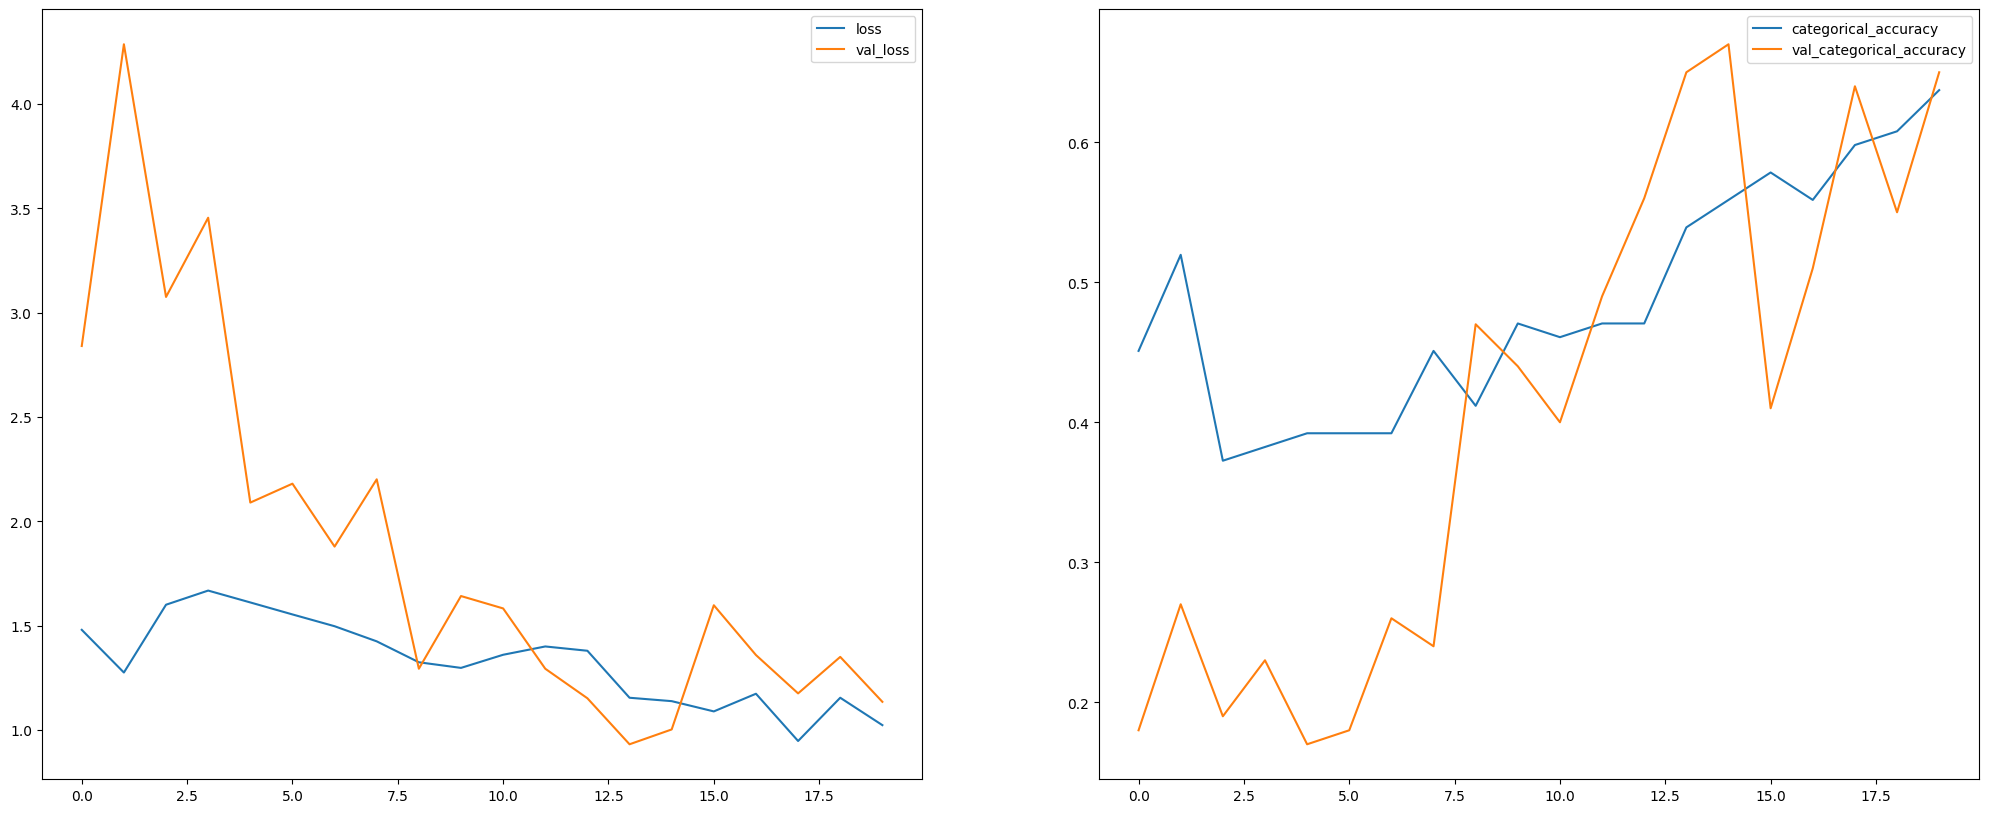

In [33]:
fn_print_header(f"Visualize Training Results for {model_name}")
fn_plot_model_accuracy(model)

## Model_5 with Conv2D with LSTM Model

In [54]:
model = Sequential()

model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'), input_shape=(18,75,75,3)))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
     
model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
     
model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
     
model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Flatten()))
model.add(LSTM(64))
     
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.5))
     
model.add(Dense(5, activation='softmax'))

In [55]:
model_name = "Model_5"

fn_print_header(f"Printing {model_name} Summary")
model_5 = fn_model_compile(model, "Adam")

----------------------------------------------------------------------------------------------------
Printing Model_5 Summary
---------------------------------------------------------------------------------------------------- 

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_95 (TimeDis (None, 18, 75, 75, 16)    448       
_________________________________________________________________
time_distributed_96 (TimeDis (None, 18, 75, 75, 16)    64        
_________________________________________________________________
time_distributed_97 (TimeDis (None, 18, 37, 37, 16)    0         
_________________________________________________________________
time_distributed_98 (TimeDis (None, 18, 37, 37, 32)    4640      
_________________________________________________________________
time_distributed_99 (TimeDis (None, 18, 37, 37, 32)    128       
______________________

In [56]:
frames=18
train_generator, val_generator = fn_val_train_generator(frames, x_dim, y_dim)
callbacks_list = fn_model_checkpoint(model_name)
steps_per_epoch, validation_steps = fn_val_epoch_steps()
fn_session_config()

fn_print_header(f"Running {model_name} Fit")    
model_5 = fn_fit(train_generator, val_generator, steps_per_epoch, validation_steps, callbacks_list)

----------------------------------------------------------------------------------------------------
Running Model_5 Fit
---------------------------------------------------------------------------------------------------- 

Source path =  Project_data/train ; batch size = 20
Epoch 1/20
34/34 [==============================] - 224s 7s/step - loss: 1.4996 - categorical_accuracy: 0.3469 - val_loss: 1.5821 - val_categorical_accuracy: 0.1700

Epoch 00001: saving model to Model_5_2022-11-1608_44_22.194016\model-00001-1.49963-0.34691-1.58211-0.17000.h5
Epoch 2/20
34/34 [==============================] - 70s 2s/step - loss: 1.4283 - categorical_accuracy: 0.3725 - val_loss: 1.6042 - val_categorical_accuracy: 0.1900

Epoch 00002: saving model to Model_5_2022-11-1608_44_22.194016\model-00002-1.42834-0.37255-1.60422-0.19000.h5
Epoch 3/20
34/34 [==============================] - 64s 2s/step - loss: 1.4854 - categorical_accuracy: 0.2941 - val_loss: 1.6641 - val_categorical_accuracy: 0.1700

Epoch 00

----------------------------------------------------------------------------------------------------
Visualize Training Results for Model_5
---------------------------------------------------------------------------------------------------- 



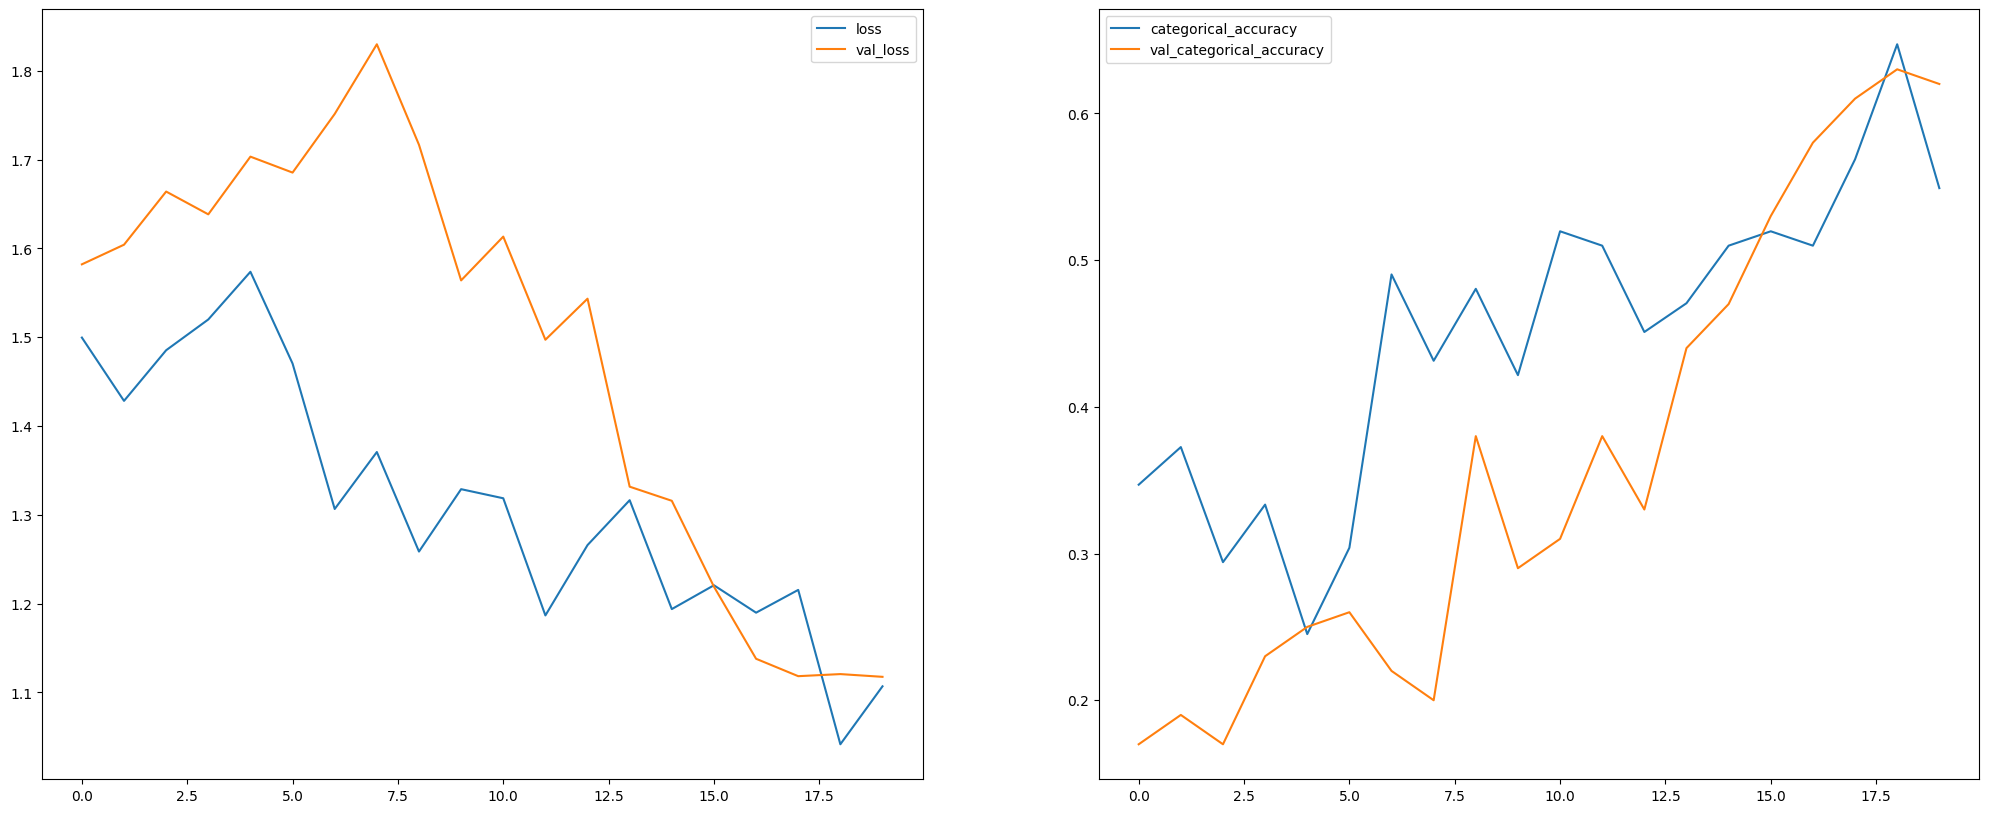

In [57]:
fn_print_header(f"Visualize Training Results for {model_name}")
fn_plot_model_accuracy(model)

## Model_6 Conv2D with GRU

In [58]:
model = Sequential()

model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'), input_shape=(18,75,75,3)))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
     
model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
     
model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
     
model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Flatten()))
model.add(GRU(64))
     
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.5))
     
model.add(Dense(5, activation='softmax'))

In [59]:
model_name = "Model_6"

fn_print_header(f"Printing {model_name} Summary")
model_6 = fn_model_compile(model, "Adam")

----------------------------------------------------------------------------------------------------
Printing Model_6 Summary
---------------------------------------------------------------------------------------------------- 

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_108 (TimeDi (None, 18, 75, 75, 16)    448       
_________________________________________________________________
time_distributed_109 (TimeDi (None, 18, 75, 75, 16)    64        
_________________________________________________________________
time_distributed_110 (TimeDi (None, 18, 37, 37, 16)    0         
_________________________________________________________________
time_distributed_111 (TimeDi (None, 18, 37, 37, 32)    4640      
_________________________________________________________________
time_distributed_112 (TimeDi (None, 18, 37, 37, 32)    128       
______________________

In [60]:
train_generator, val_generator = fn_val_train_generator(frames, x_dim, y_dim)
callbacks_list = fn_model_checkpoint(model_name)
steps_per_epoch, validation_steps = fn_val_epoch_steps()
fn_session_config()

fn_print_header(f"Running {model_name} Fit")    
model_6 = fn_fit(train_generator, val_generator, steps_per_epoch, validation_steps, callbacks_list)

----------------------------------------------------------------------------------------------------
Running Model_6 Fit
---------------------------------------------------------------------------------------------------- 

Source path =  Project_data/train ; batch size = 20
Epoch 1/20
34/34 [==============================] - 146s 4s/step - loss: 1.5046 - categorical_accuracy: 0.3288 - val_loss: 1.8720 - val_categorical_accuracy: 0.2100

Epoch 00001: saving model to Model_6_2022-11-1608_44_22.194016\model-00001-1.50462-0.32881-1.87201-0.21000.h5
Epoch 2/20
34/34 [==============================] - 32s 967ms/step - loss: 1.5759 - categorical_accuracy: 0.3333 - val_loss: 2.1240 - val_categorical_accuracy: 0.2300

Epoch 00002: saving model to Model_6_2022-11-1608_44_22.194016\model-00002-1.57595-0.33333-2.12399-0.23000.h5
Epoch 3/20
34/34 [==============================] - 38s 1s/step - loss: 1.4714 - categorical_accuracy: 0.3824 - val_loss: 2.1076 - val_categorical_accuracy: 0.2200

Epoch

----------------------------------------------------------------------------------------------------
Visualize Training Results for Model_6
---------------------------------------------------------------------------------------------------- 



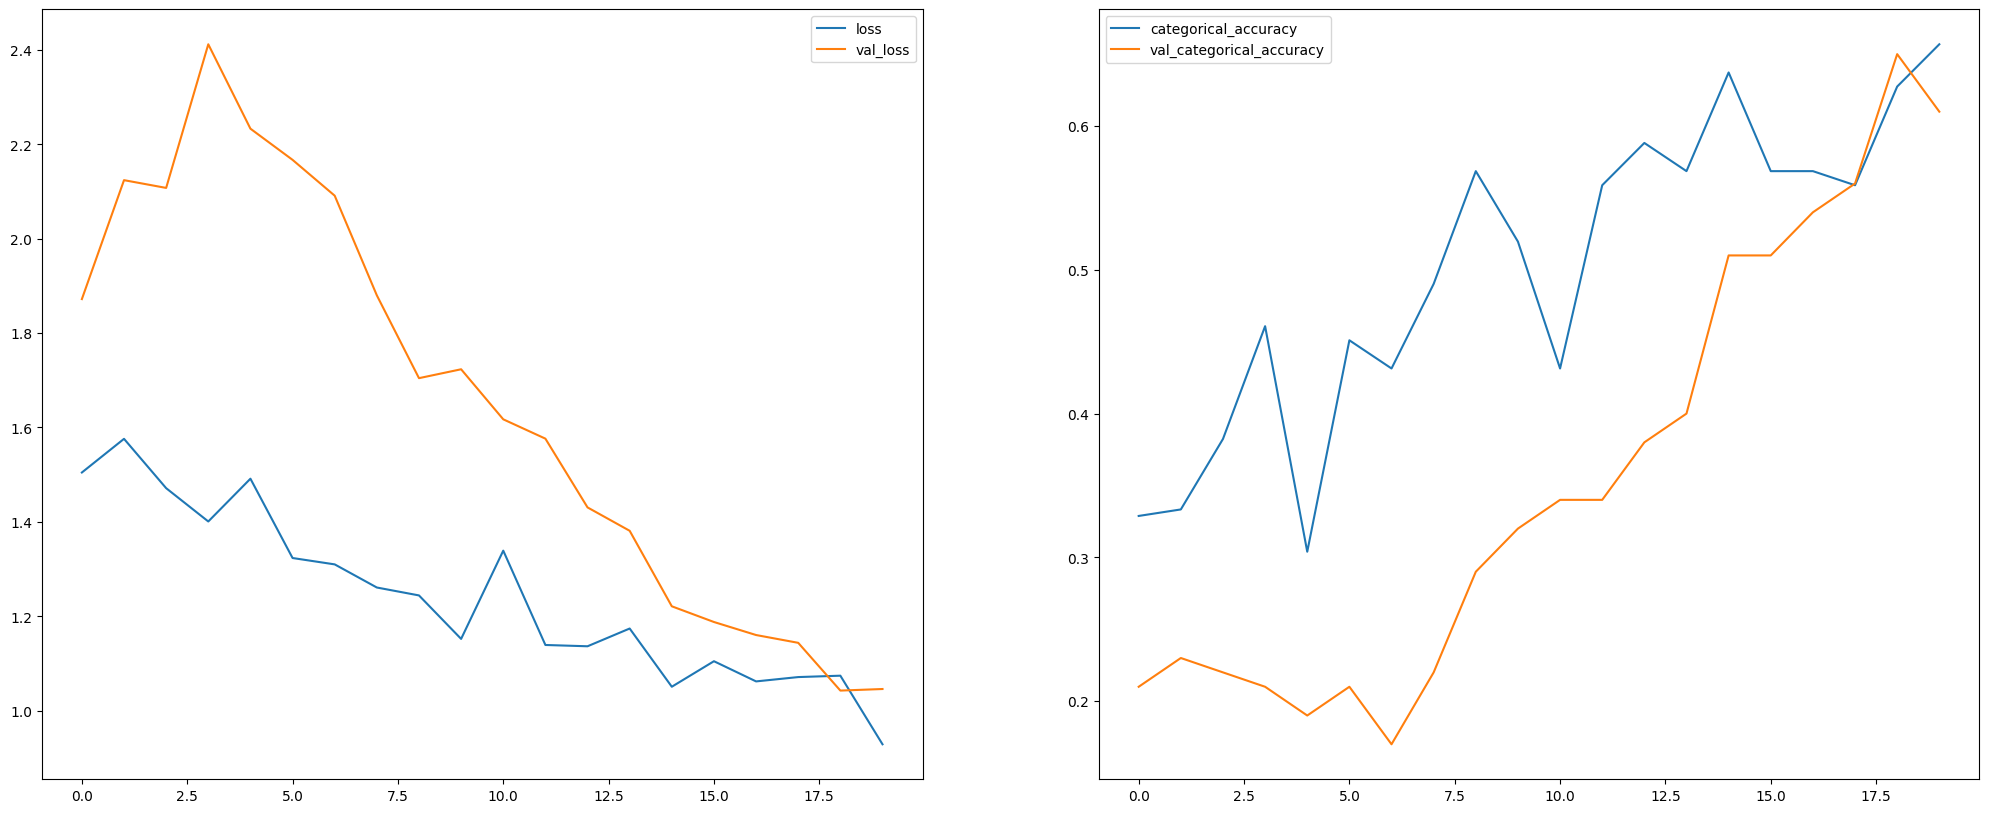

In [61]:
fn_print_header(f"Visualize Training Results for {model_name}")
fn_plot_model_accuracy(model)

## Model_7 Transfer Learning with LSTM

In [68]:
from keras.applications import mobilenet

mobilenet_transfer = mobilenet.MobileNet(weights="imagenet", include_top=False)

model = Sequential()
model.add(TimeDistributed(mobilenet_transfer,input_shape=(18,75,75,3)))

for layer in model.layers:
    layer.trainable= False
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(TimeDistributed(Flatten()))

model.add(LSTM(256))
model.add(Dropout(0.2))
        
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.5))
        
model.add(Dense(5, activation='softmax'))

In [70]:
model_name = "Model_7"

fn_print_header(f"Printing {model_name} Summary")
model_7 = fn_model_compile(model, "Adam")

----------------------------------------------------------------------------------------------------
Printing Model_7 Summary
---------------------------------------------------------------------------------------------------- 

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_129 (TimeDi (None, 18, 2, 2, 1024)    3228864   
_________________________________________________________________
time_distributed_130 (TimeDi (None, 18, 2, 2, 1024)    4096      
_________________________________________________________________
time_distributed_131 (TimeDi (None, 18, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_132 (TimeDi (None, 18, 1024)          0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 256)               1311744   
______________________

In [71]:
train_generator, val_generator = fn_val_train_generator(frames, x_dim, y_dim)
callbacks_list = fn_model_checkpoint(model_name)
steps_per_epoch, validation_steps = fn_val_epoch_steps()
fn_session_config()

fn_print_header(f"Running {model_name} Fit")    
model_6 = fn_fit(train_generator, val_generator, steps_per_epoch, validation_steps, callbacks_list)

----------------------------------------------------------------------------------------------------
Running Model_7 Fit
---------------------------------------------------------------------------------------------------- 

Source path =  Project_data/train ; batch size = 20
Epoch 1/20
34/34 [==============================] - 236s 7s/step - loss: 1.3511 - categorical_accuracy: 0.4540 - val_loss: 0.9101 - val_categorical_accuracy: 0.6700

Epoch 00001: saving model to Model_7_2022-11-1608_44_22.194016\model-00001-1.35107-0.45400-0.91006-0.67000.h5
Epoch 2/20
34/34 [==============================] - 65s 2s/step - loss: 0.8402 - categorical_accuracy: 0.7255 - val_loss: 0.9912 - val_categorical_accuracy: 0.6200

Epoch 00002: saving model to Model_7_2022-11-1608_44_22.194016\model-00002-0.84021-0.72549-0.99119-0.62000.h5
Epoch 3/20
34/34 [==============================] - 64s 2s/step - loss: 0.9210 - categorical_accuracy: 0.6667 - val_loss: 0.8958 - val_categorical_accuracy: 0.6500

Epoch 00

----------------------------------------------------------------------------------------------------
Visualize Training Results for Model_7
---------------------------------------------------------------------------------------------------- 



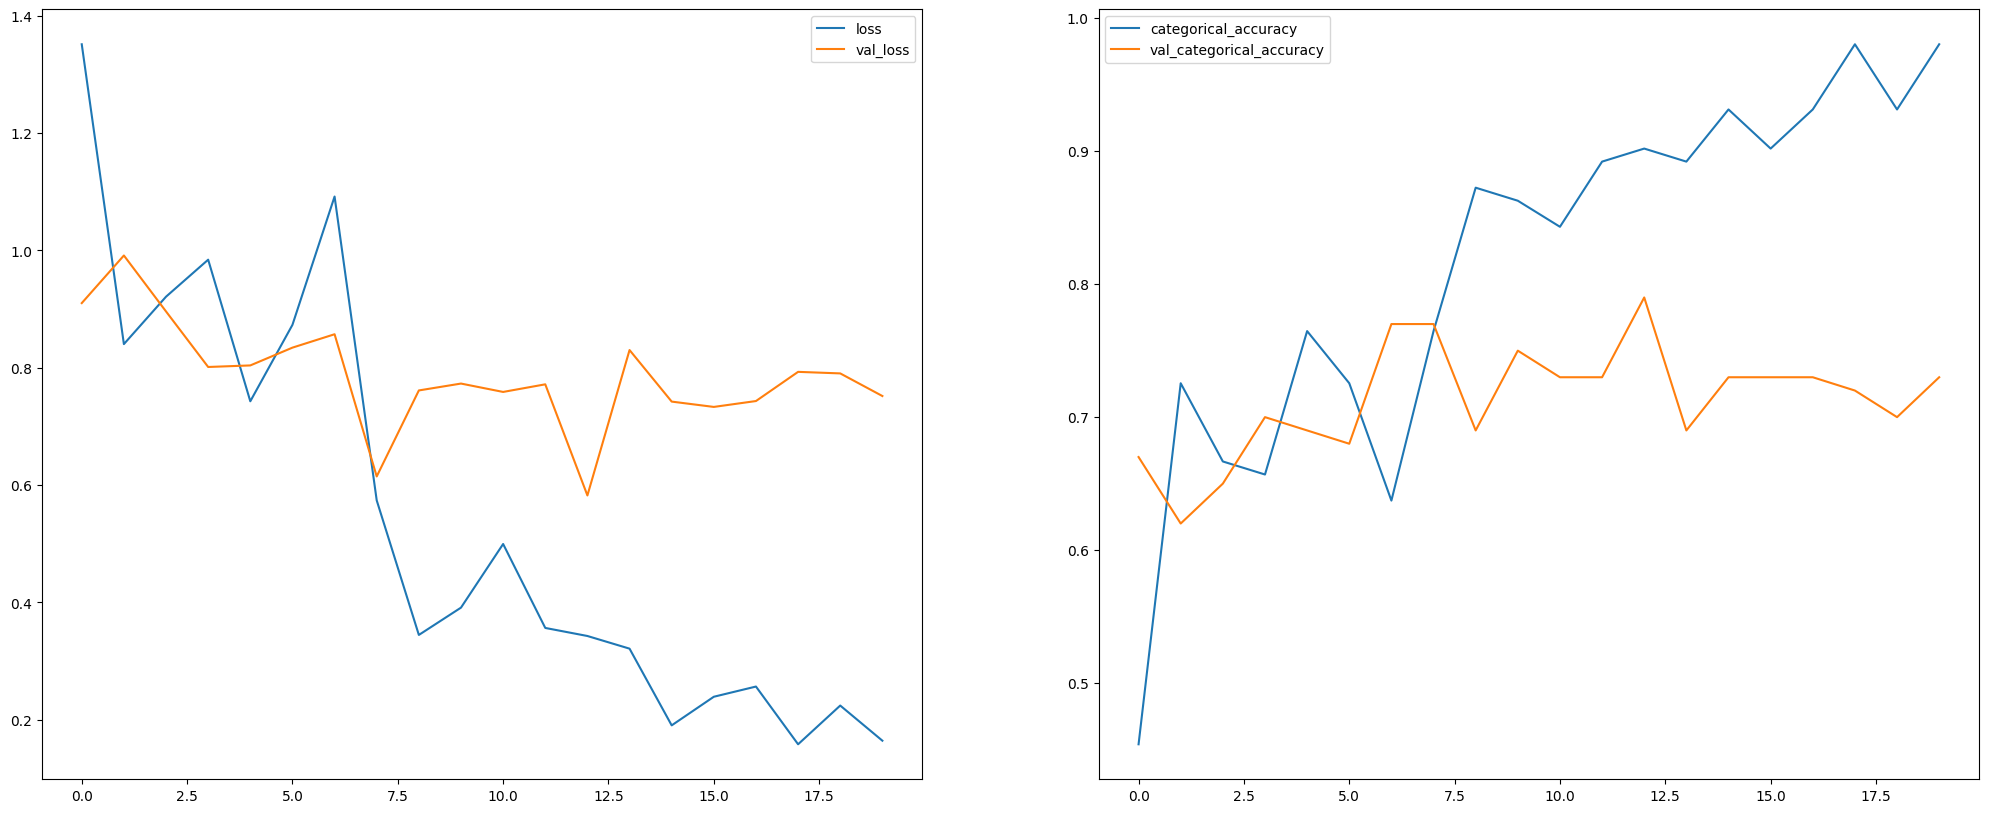

In [73]:
fn_print_header(f"Visualize Training Results for {model_name}")
fn_plot_model_accuracy(model)


<hr>
<font color = blue>
    <b>CONCLUSIONS: </b>
    <ul>
        <li>NOTE: The model was built on a personal laptop with a NVIDIA GeForce MX450 2GB Graphics Card. Due to constraints on the available compute resources, model parameters were restricted.
    <li>Model training time increased with the number of frames and size of image. Due to compute resource restrictions, frames = 20 and image (75, 75) were used to build the model. Any value higher than these threw an OOM error.
    <li>Conv3D with Adam Optimizer performed slightly better than Conv3D with SGD Optimizer and hence, Adam Optimizer was used for further models
    <li>Conv3D model with smaller filter(2x2x2) and reduced parameters performed a bit better than the Conv3D model with a (3x3x3) filter due to the filter size.
    <li>Conv2D with LSTM/GRU model had to be built with frames =18 to prevent OOM error. 
    <li>CONV3D model performed better than Conv2D model for similar parameters.
    <li>Transfer learning model has performed the best and is the final model. 
    <li>NOTE: Uploaded h5 for the top 2 Models
        <br>
    -- Conv3D with Adam Optimizer (Reduced Parameters) --> model-00020-0.87244-0.71569-0.72458-0.77000.h5
        <br>
    -- Transfer Learning with LSTM --> model-00020-0.16450-0.98039-0.75175-0.73000.h5
    </ul>
</font>
<hr>
